# Download data

In [ ]:
""" ONLY ONE TIME 

import json
from pathlib import Path

# Provide your Kaggle API credentials
kaggle_json = {
    "username": "vanfourold",
    "key": "5b95c8e0e1303081f57adc898b9ed23f"
}

# Write Kaggle API credentials to a file
kaggle_json_path = Path("kaggle.json")
with open(kaggle_json_path, "w") as f:
    json.dump(kaggle_json, f)

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle library
!pip install -q kaggle

# Download dataset (replace 'dataset-name' with the desired dataset name from Kaggle)
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

# Unzip the dataset
!unzip gtzan-dataset-music-genre-classification.zip
#Sashimi code 
!git clone https://github.com/albertfgu/diffwave-sashimi.git #download the repo
## INSTALL PACKAGE 
!pip install einops
!pip install pytorch_lightning

"""

In [66]:
import os
import librosa
import numpy as np

data_path = "/Users/fourold/Desktop/CS782/Assignment2/Data/genres_original/classical"  # Path to your "Data" folder
SR = 3000
def load_raw_audio(data_path):
    wav_files = []
    for filename in os.listdir(data_path):
        if filename.endswith(".wav"):
            filepath = os.path.join(data_path, filename)
            data, sr = librosa.load(filepath, sr=SR)  # Load with original sampling rate
            wav_files.append(data)
    return wav_files

# Load raw audio data
data =load_raw_audio(data_path) #np.array(load_raw_audio(data_path))

#data.shape

In [67]:

from torch.utils.data import Dataset, DataLoader
class AudioDataset(Dataset):
    def __init__(self, data, length=90000):
        self.data = data
        self.length = length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming that each row of data is an individual sample
        sample = torch.tensor(self.data[idx], dtype=torch.float32)  # Convert to PyTorch tensor
        # Truncate or pad the sample to the desired length
        if len(sample) > self.length:
            sample = sample[:self.length]
        elif len(sample) < self.length:
            padding = torch.zeros(self.length - len(sample))
            sample = torch.cat((sample, padding))
        # Add a channel dimension: (1, length)
        sample = sample.unsqueeze(0)
        return sample
    
    
    
    


In [68]:
def load_data(dataset, batch_size=1, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
data_loader = load_data(data, batch_size=10, shuffle=False)

In [69]:

from sklearn.model_selection import train_test_split

train_data , test_data = train_test_split(data, test_size=0.2, random_state=42)
# Instantiate the dataset
train_dataset = AudioDataset(train_data)
test_dataset = AudioDataset(test_data)

# Create a DataLoader
def load_data(dataset, batch_size=1, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Now you can use the DataLoader in your training loop
train_loader = load_data(train_dataset, batch_size=10, shuffle=True)  # Example batch size
test_loader = load_data(test_dataset, batch_size=10, shuffle=False)  # Example batch size


In [70]:
len(train_loader)

8

In [ ]:
%cd /Users/fourold/Desktop/CS782/Assignment2/d_sashimi/models


In [7]:
# you can use S4 by  S4(d_model, l_max=L, bidirectional=True)  
# d_model is the input channel = 1 , L is audio size = 900000
"""Minimal version of S4D with extra options and features stripped out, for pedagogical purposes."""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1):
        super(Conv, self).__init__()
        self.padding = dilation * (kernel_size - 1) // 2
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation, padding=self.padding)
        self.conv = nn.utils.weight_norm(self.conv)
        nn.init.kaiming_normal_(self.conv.weight)

    def forward(self, x):
        out = self.conv(x)
        return out
#from src.models.nn import DropoutNd
class TransposedLN(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.m = nn.Parameter(torch.zeros(1))
        self.s = nn.Parameter(torch.ones(1))

    def forward(self, x):
        s, m = torch.std_mean(x, dim=-2, unbiased=False, keepdim=True)
        y = (self.s/s) * (x-m+self.m)
        return y

class FF(nn.Module):
    def __init__(self, d_model, expand=2):
        super().__init__()
        d_inner = expand * d_model

        linear1 = Conv(d_model, d_inner, 1)
        linear2 = Conv(d_inner, d_model, 1)

        self.ff = nn.Sequential(
            linear1,
            nn.GELU(),
            linear2,
        )

    def forward(self, x, *args, **kwargs):
        return self.ff(x)


class S4DBlock(nn.Module):
    def __init__(self, d_model, expand=2):
        super(S4DBlock, self).__init__()
        d_inner = expand * d_model

        self.norm1 = TransposedLN(d_model)  # LayerNorm(y)
        self.norm2 = TransposedLN(d_model)  # LayerNorm(y)
        self.s4 = S4D(d_model, d_state=20, dropout = 0.0) # S4(y)
        #self.linear1 =  Conv(d_model, d_inner, 1)  # W y + b.  ( d - > n)
        self.linear2 =  Conv(d_model, d_inner, 1)  # W1 y + b1 ( n-> d? )
        self.linear3 =  Conv(d_inner, d_model, 1)  # W2 y + b2
        self.gelu = nn.GELU()  # φ(y)

    def forward(self, x):
        # Block 1
        y = x
        #y = self.norm1(y)
        #y = self.s4(y)#y, _ = self.s4(y)
        #y = self.gelu(y)
        #y = self.linear1(y) #alread in the S4 ?
        #y = x + y

        # Block 2
        #x = y
        y = self.norm2(y)
        y = self.linear2(y)  # Use linear2 here
        y = self.gelu(y)
        y = self.linear3(y)
        y = x + y

        return y
class S4DKernel(nn.Module):
    """Generate convolution kernel from diagonal SSM parameters."""

    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        super().__init__()
        # Generate dt
        H = d_model
        log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)

        C = torch.randn(H, N // 2, dtype=torch.cfloat)
        self.C = nn.Parameter(torch.view_as_real(C))
        self.register("log_dt", log_dt, lr)

        log_A_real = torch.log(0.5 * torch.ones(H, N//2))
        A_imag = math.pi * repeat(torch.arange(N//2), 'n -> h n', h=H)
        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

    def forward(self, L):
        """
        returns: (..., c, L) where c is number of channels (default 1)
        """

        # Materialize parameters
        dt = torch.exp(self.log_dt) # (H)
        C = torch.view_as_complex(self.C) # (H N)
        A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

        # Vandermonde multiplication
        dtA = A * dt.unsqueeze(-1)  # (H N)
        K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
        C = C * (torch.exp(dtA)-1.) / A
        K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real

        return K

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)


class S4D(nn.Module):
    def __init__(self, d_model, d_state=64, dropout=0.0, transposed=True, **kernel_args):
        super().__init__()

        self.h = d_model
        self.n = d_state
        self.d_output = self.h
        self.transposed = transposed

        self.D = nn.Parameter(torch.randn(self.h))

        # SSM Kernel
        self.kernel = S4DKernel(self.h, N=self.n, **kernel_args)

        # Pointwise
        self.activation = nn.GELU()
        dropout_fn = nn.Dropout#2d # NOTE: bugged in PyTorch 1.11
        #dropout_fn = DropoutNd
        self.dropout = dropout_fn(dropout) if dropout > 0.0 else nn.Identity()

        # position-wise output transform to mix features
        self.output_linear = nn.Sequential(
            nn.Conv1d(self.h, 2*self.h, kernel_size=1),
            nn.GLU(dim=-2),
        )

    def forward(self, u, **kwargs): # absorbs return_output and transformer src mask
        """ Input and output shape (B, H, L) """
        if not self.transposed: u = u.transpose(-1, -2)
        L = u.size(-1)

        # Compute SSM Kernel
        k = self.kernel(L=L) # (H L)

        # Convolution
        k_f = torch.fft.rfft(k, n=2*L) # (H L)
        u_f = torch.fft.rfft(u, n=2*L) # (B H L)
        y = torch.fft.irfft(u_f*k_f, n=2*L)[..., :L] # (B H L)

        # Compute D term in state space equation - essentially a skip connection
        y = y + u * self.D.unsqueeze(-1)

        y = self.dropout(self.activation(y))
        y = self.output_linear(y)
        if not self.transposed: y = y.transpose(-1, -2)
        return y#, None # Return a dummy state to satisfy this repo's interface, but this can be modified
import torch
import torch.nn as nn

class S4_AE(nn.Module):
    def __init__(self, input_dim=None):
        super(S4_AE, self).__init__()
        layer = [2**i for i in range(4)] # [1,2,4,8]
        #H = [2**i for i in range(5)]
        #L = [900000//i for i in H]
        #H_  = H[::-1]
        #L_  = L[::-1]
        #totalH , totalL = H+H_[1:] , L+L_[1:]
        
        self.d_layer = nn.ModuleList()  # Define d_layer as a ModuleList
        for index, i in enumerate(layer):
            #if index == 0:
                #self.d_layer.append(S4D(1, d_state=64, dropout=0.2))
            if index == 1:
                self.d_layer.append(S4D(2, d_state=10, dropout=0.2))
                #self.d_layer.append(S4DBlock( 2))
            self.d_layer.append(nn.Conv1d(i, 2*i, 2, stride=2))
            
        self.u_layer = nn.ModuleList()  # Define u_layer as a ModuleList
        for index , i  in enumerate(layer[::-1]): # i is the layer , index .... 
            self.u_layer.append(nn.ConvTranspose1d(2*i, (2*i)//2, 2, stride=2)) #S4D(d_model, d_state=64, dropout=0.0, transposed=True)
            if index == 2 : 
                self.u_layer.append(S4D(2, d_state=10, dropout=0.2))
                #self.u_layer.append(S4DBlock(2))
            if index  == 3:
                
                self.u_layer.append(S4D(1, d_state=10, dropout=0.2))
                #self.u_layer.append(S4DBlock( 1))
         
    def forward(self, x):
        for layer in self.d_layer:
            x = layer(x)
        for layer in self.u_layer:
            x = layer(x)
        return x


In [72]:

class S4D_AE(nn.Module):
    def __init__(self, input_dim=None):
        super(S4D_AE, self).__init__()
        self.s4d_1 =S4D(1, d_state=10, dropout=0.0)
        self.s4d_2 =S4D(2, d_state=10, dropout=0.0)
        self.s4d_4 =S4D(4, d_state=64, dropout=0.2)
        self.norm = nn.LayerNorm(90000)
        self.d1 =nn.Conv1d(1, 2, 2, stride=2)
        self.norm_1 = nn.LayerNorm(45000)
        self.d2 = nn.Conv1d(2, 4, 2, stride=2)
        self.norm_2 = nn.LayerNorm(22500)
        self.u1 = nn.ConvTranspose1d(4, 2 , 2, stride=2)
        self.u2 = nn.ConvTranspose1d(2, 1 , 2, stride=2)
        self.gelu = nn.GELU()
         
    def forward(self, x): #(1,1,90000)
            x = self.norm(x)
            x = self.s4d_1(x) # (B,H,L) - > (B,H ,L)
            x = self.d1(x) # 1,1,90000 -> 1,2,45000
            x = self.norm_1(x)
            x = self.s4d_2(x) # (B,H,L) - > (B,H ,L)
            x = self.gelu(x)
            x = self.norm_1(x)
            """
            x = self.d2(x) #  1,2,45000 -> 1,4,22500 XXXXX
            x = self.norm_2(x)
            x = self.s4d_4(x) # (B,H,L) - > (B,H ,L) XXXXX
            x = self.u1(x) #  1,4,22500 -> 1,2,45000 XXXXX
            x = self.norm_1(x)
            x = self.s4d_2(x) # (B,H,L) - > (B,H ,L) XXXXX"""
            x = self.u2(x) #  1,2,45000 -> 1,1,90000
            x = self.norm(x)
            x = self.s4d_1(x) # (B,H,L) - > (B,H ,L)
            x = self.gelu(x)
            #x = self.norm(x)
            return x


In [73]:
import torch
import torch.nn as nn
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # Reconstruction loss
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print('Epoch %d, Train Loss: %.3f' % (epoch + 1, train_loss))

        # Evaluate on test set
        model.eval()  # Set model to evaluation mode
        test_loss = 0.0
        with torch.no_grad():
            for data in test_loader:
                inputs = data
                outputs = model(inputs)
                test_loss += criterion(outputs, inputs).item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        print('Epoch %d, Test Loss: %.3f' % (epoch + 1, test_loss))

    print('Finished Training')
    return train_losses, test_losses

In [74]:
import torch.optim as optim

S4D_autoencoder = S4D_AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(S4D_autoencoder.parameters(), lr=0.001)
epochs = 30


In [75]:


train_losses, test_losses = train_model(S4D_autoencoder, train_loader, test_loader, criterion, optimizer, epochs)

Epoch 1, Train Loss: 0.195
Epoch 1, Test Loss: 0.187
Epoch 2, Train Loss: 0.186
Epoch 2, Test Loss: 0.178
Epoch 3, Train Loss: 0.177
Epoch 3, Test Loss: 0.169
Epoch 4, Train Loss: 0.168
Epoch 4, Test Loss: 0.161
Epoch 5, Train Loss: 0.159
Epoch 5, Test Loss: 0.152
Epoch 6, Train Loss: 0.150
Epoch 6, Test Loss: 0.143
Epoch 7, Train Loss: 0.141
Epoch 7, Test Loss: 0.134
Epoch 8, Train Loss: 0.131
Epoch 8, Test Loss: 0.125
Epoch 9, Train Loss: 0.122
Epoch 9, Test Loss: 0.115
Epoch 10, Train Loss: 0.112
Epoch 10, Test Loss: 0.106
Epoch 11, Train Loss: 0.103
Epoch 11, Test Loss: 0.098
Epoch 12, Train Loss: 0.094
Epoch 12, Test Loss: 0.089
Epoch 13, Train Loss: 0.086
Epoch 13, Test Loss: 0.080
Epoch 14, Train Loss: 0.077
Epoch 14, Test Loss: 0.072
Epoch 15, Train Loss: 0.068
Epoch 15, Test Loss: 0.063
Epoch 16, Train Loss: 0.059
Epoch 16, Test Loss: 0.054
Epoch 17, Train Loss: 0.050
Epoch 17, Test Loss: 0.046
Epoch 18, Train Loss: 0.041
Epoch 18, Test Loss: 0.037
Epoch 19, Train Loss: 0.032


In [90]:
import torch

# Define the file path where you want to save the model
file_path = 'S4_model_classical.pth'

# Save the model
torch.save(S4D_autoencoder.state_dict(), file_path)
#model.load_state_dict(torch.load(file_path))

In [79]:
#made a generative with test sample
sample = None
for sample in test_loader:
    with torch.no_grad():
        sample = sample
        reconstructed = S4D_autoencoder(sample)
#(B,H,L)->+ S4D +(B,2*H, L/2)+ S4D() ->( B,H L)

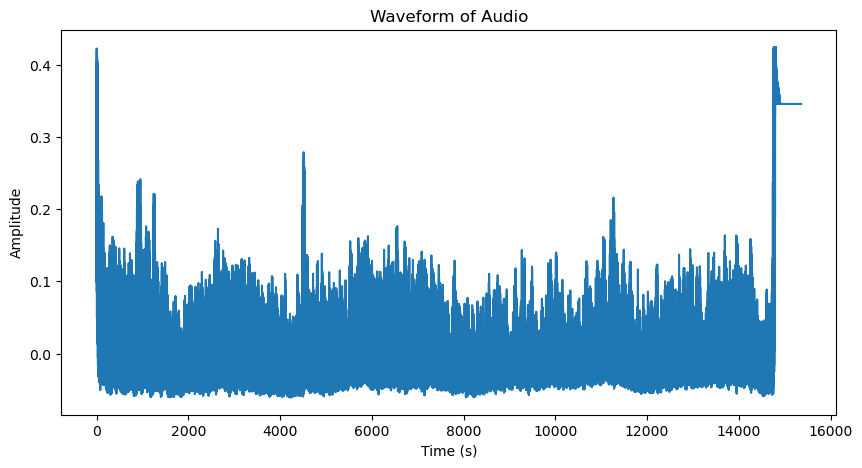

In [80]:
import librosa
import matplotlib.pyplot as plt

def plot_waveform(audio_waveform, sampling_rate):
    """
    
    Plot the waveform of a single audio clip.

    Args:
    - audio_waveform (numpy.ndarray): Array containing the audio waveform.
    - sampling_rate (int): Sampling rate of the audio clip.
    """
    plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
    time = librosa.times_like(audio_waveform, sr=sampling_rate)
    plt.plot(time, audio_waveform)  # Plot the waveform
    plt.title("Waveform of Audio")  # Add a title
    plt.xlabel("Time (s)")  # Label for x-axis
    plt.ylabel("Amplitude")  # Label for y-axis
    plt.show()

audio_signal ,sr = reconstructed[1][0] , 3000
plot_waveform(audio_signal,sr)

In [111]:
from IPython.display import Audio

sr = 3000  # Sampling rate
import torch

# Play the audio
print("generate :")
Audio(reconstructed[0], rate=sr)

generate :


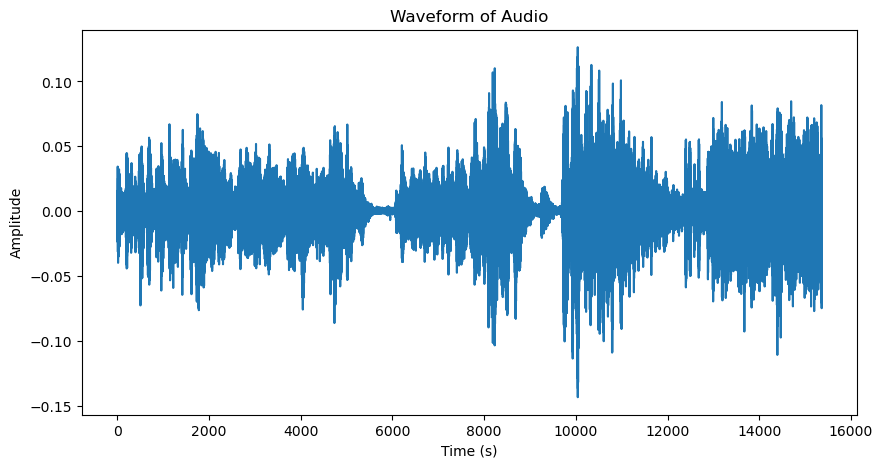

In [116]:
plot_waveform(sample[0][0],sr)

In [113]:
Audio(sample[0], rate=sr)

### Compare result

In [84]:
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm
from keras.models import Model

# calculate frechet inception distance using encoder of VAE model

def calculate_fid(encoder, audio1, audio2): #( inception model , audio1 , audio2 )
    # encode audio using the encoder
    enc1 = encoder.predict(audio1) # (batch , laten space of audio 1 )
    
    enc2 = encoder.predict(audio2) # (batch , laten space of audio 1 )

    # calculate mean and covariance statistics
    mu1, sigma1 = enc1.mean(axis=0), cov(enc1, rowvar=False)
    mu2, sigma2 = enc2.mean(axis=0), cov(enc2, rowvar=False)

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [95]:
noise_shape = (1,1,90000)
noise = torch.randn(noise_shape)

In [99]:
Audio(noise[0] ,rate = 3000)

In [107]:
y = S4D_autoencoder(noise)
y = y.detach().numpy() 

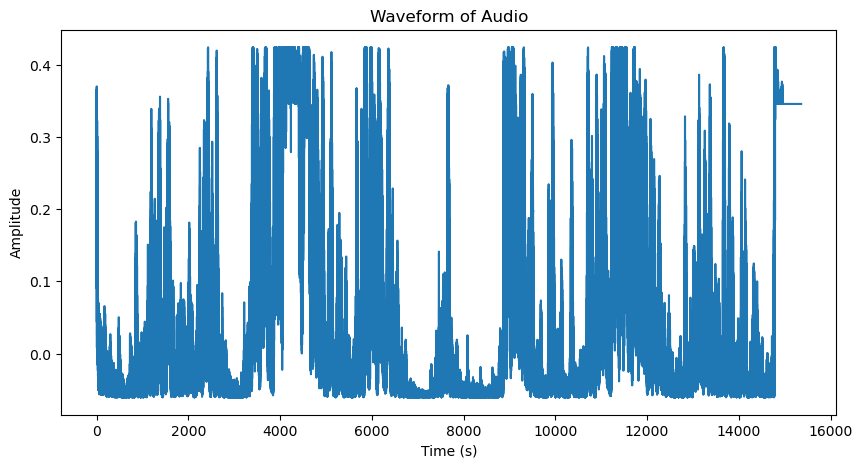

In [109]:
audio_signal ,sr = y[0][0] , 3000
plot_waveform(audio_signal,sr)

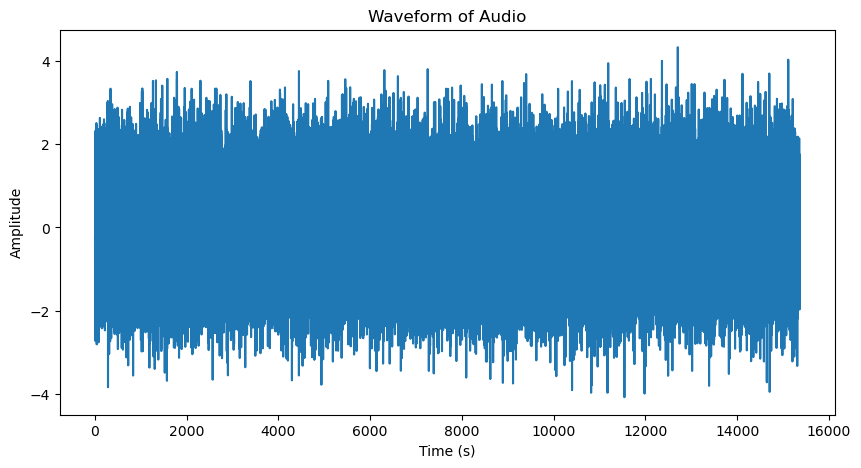

In [117]:
audio_signal ,sr = noise[0][0] , 3000
plot_waveform(audio_signal,sr)

In [110]:
Audio(y[0] ,rate = 3000)